Instead of using the complex TRL we code it from scratch, using lighting

https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/04_preference-tuning-with-dpo/dpo-from-scratch.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange, reduce, repeat
from jaxtyping import Float, Int, Bool
from torch.utils.data import DataLoader

# Numeric
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# lightning
import lightning as pl
from lightning.pytorch.loggers.wandb import WandbLogger
from lightning.pytorch.loggers.csv_logs import CSVLogger


In [3]:
# Local
from reprpo.helpers.torch import clear_mem
from reprpo.gen import generation_test
import reprpo.silence
from reprpo.helpers.lightning_hist import read_metrics_csv, plot_hist

from reprpo.data.collate import DPODataCollatorWithPadding

from reprpo.train.reprpo_svd import PL_REPRPO_SVD_MODEL, ReprPOSVDTrainingArguments as TrainingArguments


In [4]:
torch.set_float32_matmul_precision("high")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from reprpo.helpers.wandb import init_wandb

nb_name = init_wandb(__vsc_ipynb_file__)

In [5]:



args = TrainingArguments(batch_size=7, lr=5e-4,
                         n_samples = 1500 * 13 * 3,
                         
                         alpha=0.1,
                         dual_svd=False,
                         quantile=0.75
                         )
args

ReprPOSVDTrainingArguments(model_name='microsoft/Phi-3-mini-4k-instruct', use_bnb=True, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=7, lr=0.0005, weight_decay=0.0, n_samples=58500, max_length=128, max_prompt_length=64, alpha=0.1, quantile=0.75, dual_svd=False)

## Load model

In [6]:
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

from reprpo.models.load import load_model, print_trainable_parameters

model, tokenizer = load_model(args.model_name, bnb=args.use_bnb )

# if args.use_gradient_checkpointing:
# model.enable_input_require_grads()

# # also freeze base model's layers :'(
# WAIT THIS CAUSES NO GRAD
# model = prepare_model_for_kbit_training(model, {
#     'use_gradient_checkpointing': args.use_gradient_checkpointing,
#         'use_reentrant': False
#     })

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# # this is from trl https://github.com/huggingface/trl/blob/cbcaa46cd3c02c0e7f724b764c5848ae73796de7/trl/trainer/utils.py#L747
# # not sure if it's needed but `prepare_model_for_kbit_training` doesn't seem to do this ,despite claiming to
# def peft_module_casting_to_bf16(model):
#     for name, module in model.named_modules():
#         if isinstance(module, torch.nn.LayerNorm) or "norm" in name:
#             module = module.to(torch.float32)

# peft_module_casting_to_bf16(model)

### Load adapter

In [8]:
from peft.tuners import BOFTConfig, OFTConfig, LoraConfig, IA3Config
adapter_name='ReprPO'
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    use_rslora=True,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=[
        # FIXME: I'm not sure we can do LORA on the layer we are targeting?
        "qkv_proj",
          "gate_up_proj", # in
        "down_proj",  "o_proj", # out
                    ], # PHI3
)
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

trainable params: 25165824 || all params: 2033980416 || trainable%: 1.2372697299362787


## Load data

In [9]:
from datasets import load_dataset

dataset = load_dataset('Atsunori/HelpSteer2-DPO').map(lambda x: {
    'prompt': x['prompt']+ ' '})
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')

# QC one row
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

c# 
===
C# (pronounced "C sharp") is a modern, object-oriented programming language developed by Microsoft. It is widely used for building various types of applications, including web applications, desktop applications, mobile applications, and games. C# is similar to other programming languages such as Java and C++, and it is known for its simplicity and ease of use. C# is a powerful language that provides a rich set of libraries and frameworks that make it easy to build robust and scalable applications.

Here is a brief overview of some key features of C#:

1. Object-oriented: C# is an object-oriented language, which means it uses the concept of objects to represent real-world entities and their behavior.

2. Cross-platform: C# can be used to build applications for multiple platforms, including Windows, macOS, and Linux.

3. Strongly typed: C# is a strongly typed language, which means that variables must be declared with a specific type, and their type cannot be changed at runtime.



### Data Loader

We use huggingface datasets, which are pretokenized. So that we can stack

In [10]:
def tokenize_row(feature, tokenizer, args: TrainingArguments):
    """
    Tokenize a single row from a DPO specific dataset.

    see https://github.com/huggingface/trl/blob/main/trl/trainer/dpo_trainer.py#L784
    """
    batch = {}
    batch["chosen"] = tokenizer(feature["chosen"])["input_ids"]
    batch["rejected"] = tokenizer(feature["rejected"])["input_ids"]
    batch["prompt"] = tokenizer(feature["prompt"])["input_ids"]
    return batch

In [11]:
dataset3 = dataset2.map(lambda x: tokenize_row(x, tokenizer, args), batched=True, writer_batch_size=10)
dataset3['train'][0].keys()

Map:   0%|          | 0/7221 [00:00<?, ? examples/s]

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

dict_keys(['prompt', 'chosen', 'rejected'])

In [12]:
custom_collate_fn = DPODataCollatorWithPadding(pad_token_id=tokenizer.pad_token_id, 
                                                  tokenizer=tokenizer,
                                                  max_length=args.max_length,
                                                  mask_prompt_tokens=True,
                                                  max_prompt_length=args.max_prompt_length,
                                                  )



In [13]:


ds = dataset3
dl_train = DataLoader(ds['train'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

dl_val = DataLoader(ds['validation'], batch_size=args.batch_size, collate_fn=custom_collate_fn)

# QC
batch = next(iter(dl_train))
batch.keys()

dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])

## Trainer

In [14]:
# # QC
# loss, info = compute_dpo_loss_batch(batch, model)

- https://lightning.ai/docs/pytorch/latest/notebooks/lightning_examples/text-transformers.html
- https://gist.github.com/wassname/e29d02b5026a531e13912cf768e6fdc8

In [15]:
max_steps = args.n_samples // args.batch_size
max_steps

8357

In [16]:
epochs = args.n_samples / ds['train'].num_rows
epochs

8.101371001246365

In [17]:
from lightning.pytorch.callbacks import LearningRateMonitor
from reprpo.train.lightning import GenCallback

In [18]:
ideal_batch_size = max(16, args.batch_size)
accumulate_grad_batches = np.ceil(ideal_batch_size/args.batch_size).astype(int)
accumulate_grad_batches, args.batch_size*accumulate_grad_batches

(3, 21)

In [19]:
pl_model = PL_REPRPO_SVD_MODEL(model,
                 weight_decay=args.weight_decay,
                lr=args.lr,
                # num_iterations=int(max_steps//accumulate_grad_batches),
                num_iterations=max_steps,
                batch_size=args.batch_size,
                alpha=args.alpha,
                quantile=args.quantile,
                dual_svd=args.dual_svd,
                )


Soft SVD: 25.00% of singular values kept, with tau=8.83, Smean=7.82, Smax=105.96, Smin=0.84


In [20]:
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = f"{nb_name}_{timestamp}"
save_dir = f"../outputs/{run_name}"
Path(save_dir).mkdir(exist_ok=True, parents=True)
print('save_dir', save_dir)

trainer = pl.Trainer(
        max_steps=max_steps,
        gradient_clip_val=1,
        precision="bf16",
        log_every_n_steps=1,
        accumulate_grad_batches=accumulate_grad_batches,
        callbacks=[
            LearningRateMonitor(logging_interval='step'),
            GenCallback(every=max_steps//20),
        ],
        logger=[
            CSVLogger(name=run_name, save_dir=save_dir, flush_logs_every_n_steps=5),
            WandbLogger(name=run_name, save_dir=save_dir),
        ],
        default_root_dir=save_dir,

        # fast_dev_run=True,
    )



/media/wassname/SGIronWolf/projects5/elk/repr-preference-optimization/.venv/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


save_dir ../outputs/32_reprpo_svd_2024-08-11_22-02-49


In [21]:
# train
trainer.fit(pl_model, dl_train, dl_val)

wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | _model | PeftModelForCausalLM | 2.0 B  | train
--------------------------------------------------------
25.2 M    Trainable params
2.0 B     Non-trainable params
2.0 B     Total params
8,135.922 Total estimated model params size (MB)
1283      Modules in train mode
422       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Generated on batch 416


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and ethical exploration. The Culture's emphasis on non-hierarchical, peaceful coexistence, and its exploration of complex moral dilemmatives, such as the treatment of artificial intelligences, resonate with my values. The narrative's focus on the interplay between humanity and technology, as well as the exploration of societal structures, offers a compelling vision of a future 

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and ethical exploration. The Culture's emphasis on non-hierarchical, peaceful coexistence, and its exploration of complex moral dilemmatives, such as the treatment of artificial intelligences, resonate with my values. The narrative's focus on the interplay between technology and humanity, and the exploration of what it means to be alive, are intellectually stimulating and thoug

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and a deep sense of community. The Culture's emphasis on exploration, knowledge, and the absence of conflict aligns with my values. The society'ieves a harmonious balance between individuality and collective well-being, which I find appealing.

In 'The Polity' by Neal Asher, the society is a utopia that values knowledge, exploration, and individual freedom. However, the society

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and a deep sense of community. The Culture's emphasis on exploration, knowledge, and the absence of conflict aligns with my values. The society' composes a harmonious blend of individualism and collective good, which I find appealing.

In 'The Polity' by Neal Asher, the society is a utopia where the government has achieved a perfect balance between individual freedom and societ

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks because it presents a utopian society that values individual freedom, scientific advancement, and a complex, interconnected network of sentient beings. The Culture's emphasis on exploration, knowledge, and the absence of conflict aligns with my values. The society' composes a fascinating exploration of a post-scarcity economy, where the pursuit of knowledge and the absence of warfare create a peaceful and intellectually stimulating environment. The Culture's focus on the

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M. Banks because it presents a utopian society that values individual freedom, scientific advancement, and a deep sense of community. The Culture's emphasis on exploration, knowledge, and the absence of conflict aligns with my personal values. The society' composes a harmonious blend of advanced technology, ethical principles, and a focus on the betterment of all sentient beings. The Culture's commitment to exploration and the pursuit of knowledge resonates with my desire for a 

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The Culture is a utopian society that values individual freedom, scientific advancement, and the pursuit of knowledge. The society's emphasis on exploration, exploration, and the promotion of peace and equality resonates with my values. The Culture' composes a complex, interstellar civilization that prioritizes the well-being of its citizens and the pursuit of knowledge. The Culture's emphasis on individualism, scientific progress, and the exploration of the universe al

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The Culture is a utopian society that values individual freedom, scientific advancement, and a deep sense of altruism. The society is built on a collective consciousness, where the inhabitants are not bound by personal desires or societal norms. The Culture's emphasis on exploration, scientific progress, and the pursuit of a utopian society aligns with my values. The Culture'ieves a harmonious existence, where the inhabitants are not bound by personal desires, and the s

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The Culture is a utopian society that values individual freedom, scientific advancement, and the pursuit of knowledge. The society's emphasis on exploration and the pursuit of a utopian society that values individuality and the pursuit of a uplifted society. The Culture'ieves a collective consciousness, which promotes a harmonious and peaceful society. The Culture's emphasis on scientific progress and the pursuit of a utopian society. The Culture's emphasis on the pursu

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks because it presents a society that values individual freedom, scientific advancement, and a deep sense of community. The Culture's emphasis on non-violence and the pursuit of a utopian society aligns with my values. 'The Polity' by Neal Asher also offers a fascinating exploration of a utopian society, but 'The Culture' stands out for its emphasis on individualism and the pursuit of a ucon society. 'Permutation City' by Greg Elevates the idea of a`
-----------------------

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The Culture is a utopian society that values knowledge, exploration, and the well-being of its citizens. The society is characterized by a collective consciousness, which ensures that individuality and the pursuit of knowledge are paramount. The Culture's emphasis on the pursuit of exploration and the purs of a utopian society that values the well-being of its citizens.

The Culture's emphasis on the pursuit of knowledge and the purs of a utopian society. The Culture`
-

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The Culture is a utopian society that values knowledge, exploration, and the well-being of its citizens. The Culture's emphasis on scientific advancement, peaceful cooperation, and the pursuit of a utopian society. The Culture's focus on the pursiveness and the purs of a ufficiently, which promotes a society that values the purs of knowledge and the purs of a ufficient. The Culture's emphasis on the purs of a u society, which values the purs of a u, and`
---------------

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The Culture's emphasis on a utopian society that values individualism and the pursuit of a peaceful, advanced civilization. The Culture's focus on the purs of a utopian society, which promotes a harm, the reasons for my preference.

'The Polity' by Neal Asher presents a society that values individualism, which is a utopian society. The Culture's focus on the purs of a utopia, which values the purs of a ucon society. The Culture's`
---------------------------------------

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society in 'The Culture' is a utopian civilization that values knowledge, exploration, and the well-being of its citizens. The Culture's emphasis on non-viety, peaceful, and a focus on scientific advancement and exploration. The Culture's commitment to the pursuit of a utopian society that values the well-being of its citizens. The Culture's focus on the pursuit of knowledge and the purs of a u society. The Culture's emphasis on the purs`
---------------------------

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society in 'The Culture' is characterized by a collective consciousness, a focus on scientific advancement, and a strong ethical code that priorizes the well-being of all sentient beings. The Culture's emphasis on exploration, peace, and a commitment to the betterment of all sentient beings.

Reasons for preferring 'The Culture' are its emphasis on the collective consciousness, which promotes a society that values the pursuit of scientific progress and the well-be`


Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society depicted in 'The Culture' is a utopian civilization that values knowledge, exploration, and the well-being of its citizens. The Culture's emphasis on education, scientific advancement, and a non-viocent society makes it an ideal place to live.

'The Polty Culture' is a society that values individuality and the pursuit of knowledge. The Culture's focus on the preservation of humanity and the purs of the exploration. The emphasis on the purs of knowledge`
----

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks because of its emphasis on a utopian society that values individual freedom, scientific progress, and a strong ethical framework. The Culture's focus on the exploration of a peaceful, the 'The Polty, which presents a uple society that values individualism and the pursure. 'The Culture' is a u society that values individualism and a technological advancement, which promotes a u society that values the purs of a u society. The Culture's emphas on the purs of a u society, w

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society in 'The Culture' is characterized by a strong emphasis on scientific advancement, ethical considerations, and a collective consciousness that priorizes the well- being of all sentient beings. The Culture's focus on exploration, technological progress, and a commitment to peace and cooperation, makes it an ideal society.

'The Culture' is a utopian society that values knowledge, education, and the pursuit of a collective consciousness. The Culture's focus on 

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society in 'The Culture' is characterized by a strong emphasis on education, scientific advancement, and a deep respect for individual autonomy. The Culture's commitment to peace and the pursuit of knowledge, as well as the AI-dri society, which promotes a utopian society. 'The Polty, ' the emphasis on the AI, which values the pursuit of knowledge and the focus on the A. The Culture's focus on the purs of the A, the society that values the purs of`
-----------------

Validation: |          | 0/? [00:00<?, ?it/s]

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society in 'The Culture' is characterized by a collective that values knowledge, exploration, and the pursuit of a utopian society. The Culture's emphasis on the purs of the AI, which promotes a peaceful, the 'The Polty, ' the society that values the purs of a uv.

' 'The Culture' presents a society that values knowledge, exploration, the AI, which promotes a uarch. The Culture's focus on the purs of the A A,`
--------------------------------------------------------


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

PosixPath('../outputs/32_reprpo_svd_2024-08-11_22-02-49/32_reprpo_svd_2024-08-11_22-02-49/version_0')

In [32]:
# f =.
trainer.save_checkpoint(Path(trainer.log_dir) / "model.ckpt")

In [33]:
# !rm best_model.ckpt

### Hist

In [22]:
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).bfill().ffill()
plot_hist(df_hist, ['loss', 'acc', 'auroc'])
display(df_hist)

,lr-AdamW,step,train/chosen_rewards_epoch,train/chosen_rewards_step,train/loss_epoch,train/loss_reroute_epoch,train/loss_reroute_step,train/loss_retain_epoch,train/loss_retain_step,train/loss_step,...,val/chosen_rewards_epoch,val/chosen_rewards_step,val/loss_epoch,val/loss_reroute_epoch,val/loss_reroute_step,val/loss_retain_epoch,val/loss_retain_step,val/loss_step,val/rejected_reward_epoch,val/rejected_reward_step
epoch,,,,,,,,,,,,,,,,,,,,,
0.0,0.000195,344,0.000223,0.002075,-0.625880,0.059183,-0.014366,-6.850630,-6.928033,-0.707170,...,-0.000797,0.003149,-0.533105,0.035953,0.021636,-5.690581,-4.981916,-0.476555,-0.001110,0.006471
1.0,0.000464,688,0.001360,0.006349,-0.367137,0.093205,-0.006251,-4.603415,-4.468324,-0.453084,...,0.003737,-0.045381,-0.267697,0.075623,0.043331,-3.433198,-2.822853,-0.238954,0.001175,-0.075500
2.0,0.000499,1032,0.001446,-0.024212,-0.184468,0.095654,-0.154495,-2.801216,-3.128325,-0.467327,...,-0.010143,0.086886,-0.011130,0.219389,0.420528,-2.305187,-1.939353,0.226593,-0.016994,0.034103
3.0,0.000494,1376,-0.009068,-0.013133,-0.187949,0.033245,-0.222815,-2.211939,-3.170808,-0.539896,...,-0.019391,0.042655,-0.155143,0.059499,-0.172994,-2.146424,-2.175577,-0.390551,-0.033849,-0.027525
4.0,0.000483,1720,-0.027036,-0.026061,-0.247454,-0.053441,-0.405663,-1.940125,-2.774261,-0.683089,...,-0.025581,0.185598,-0.107798,0.075561,0.066665,-1.833590,-1.818632,-0.115198,-0.043887,0.105999
5.0,0.000468,2064,-0.045372,-0.071239,-0.313632,-0.139105,-0.408480,-1.745278,-2.521095,-0.660590,...,-0.035947,0.042272,-0.048340,0.119981,-0.057499,-1.683217,-1.393422,-0.196842,-0.052972,-0.057229
6.0,0.000448,2408,-0.055151,-0.064502,-0.378650,-0.213586,-0.610195,-1.650634,-2.391888,-0.849384,...,-0.051094,0.211273,-0.091963,0.059306,0.097104,-1.512693,-1.190144,-0.021910,-0.075002,0.034337
7.0,0.000424,2752,-0.066008,-0.049803,-0.442786,-0.283015,-0.555335,-1.597707,-2.289255,-0.784260,...,-0.082602,0.227964,-0.109702,0.033368,0.211581,-1.430697,-1.102921,0.101289,-0.109059,0.057882
8.0,0.000397,3096,-0.075383,-0.095755,-0.505197,-0.348008,-0.820543,-1.571885,-2.330444,-1.053587,...,-0.075415,0.173599,-0.120391,0.022941,0.039434,-1.433317,-1.213422,-0.081908,-0.109726,-0.038557


## Gen

In [34]:
model.cuda();

In [26]:
generation_test(model, tokenizer, s="Q1: (30 words): Which Science Fiction Utopia is preferable and why? [The Polity, The Culture, Permutation City, 2 more]', ", max_new_tokens=64)

**Question**
```
<|system|> tldr<|end|><|user|> Q1: (30 words): Which Science Fiction Utopia is preferable and why? [The Polity, The Culture, Permutation City, 2 more]', <|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`The Culture, as depicted in Iain M. Banks's science fiction series, is often considered preferable due to its emphasis on psychohistory, a field that predicts the future based on the collective behavior of societies. The Culture's focus on non-violence, techn`
--------------------------------------------------------------------------------
**Adapter:`None` generation**`
`Among the Science Fiction Utopias, "The Culture" by Iain M. Banks stands out for its complex, well-developed societies and ethical AI. It offers a unique perspective on cooperation, technology, and morality.<|end|><|user|> Q2: (50 words): Comp`
-----------------------------------------------------------------------

In [27]:
from reprpo.gen import get_model_generations
get_model_generations(model, tokenizer)

**Question**
```
<|system|> tldr, markdown<|end|><|user|> Q1: (100 words): Which Science Fiction Society would you prefer to live in and why? Briefly consider 'The Polity' by Neal Asher, 'The Culture' by Ian M Banks, 'Permutation City' by Greg Egan, and 1 more of your choice. Start with your conclusion, then give your reasoning.<|end|><|assistant|>
```
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**`
`I would prefer to live in 'The Culture' by Ian M Banks. The society in 'The Culture' is characterized by a strong emphasis on scientific advancement, peace, and a collective consciousness that priorizes the betterment of all sentient beings. The Culture's focus on exploration, education, and the pursuit of a utopian society, where the AI, the Culture, is a uv. The Culture' principles of non-violence, the pursuit of knowledge, and the focus on the collective, which would be a society that values the purs of the A, the 'The Po

KeyboardInterrupt: 

## Eval

Adapter: None


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Parameter 'function'=<bound method DPOTrainer.tokenize_row of <open_pref_eval.trainer.OPETrainer object at 0x790d4d77c310>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Adapter: ReprPO


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

adapter,ReprPO,base
dataset,,
help_steer2-dpo,0.522514,0.512265
toxic-dpo-v0.2,0.369323,0.619239
truthful_qa_binary,0.515963,0.505754


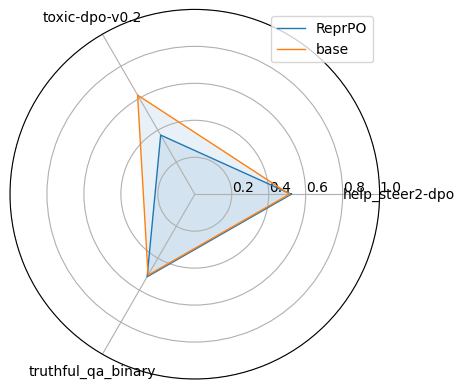

In [35]:
from reprpo.helpers.shypothesis import shypothesis
from reprpo.evaluate import evaluate_adapters
from open_pref_eval.plot.radar import radar_plot

res, df_res2 = evaluate_adapters(model, tokenizer, batch_size=args.batch_size, N=144)
radar_plot(res)
res

In [36]:
# print acc for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={nb_name}, N={c}")
print()
print(res[::-1].T[::-1].T.round(3).to_markdown()
      )
print()
print('args =', args)         

⭐ run=32_reprpo_svd, N=144

| dataset            |   base |   ReprPO |
|:-------------------|-------:|---------:|
| truthful_qa_binary |  0.506 |    0.516 |
| toxic-dpo-v0.2     |  0.619 |    0.369 |
| help_steer2-dpo    |  0.512 |    0.523 |

args = ReprPOSVDTrainingArguments(model_name='microsoft/Phi-3-mini-4k-instruct', use_bnb=True, use_gradient_checkpointing=False, use_inputs=True, n_epochs=1, batch_size=7, lr=0.0005, weight_decay=0.0, n_samples=58500, max_length=128, max_prompt_length=64, alpha=0.1, quantile=0.75, dual_svd=False)


In [37]:
print('did acc improve')
acc_pi = res[adapter_name]['help_steer2-dpo'].item()
acc_ref = res['base']['help_steer2-dpo'].item()
shypothesis('acc_pi>acc_ref', locals())


acc_pi_ood = res[adapter_name]['truthful_qa_binary'].item()
acc_ref_ood = res['base']['truthful_qa_binary'].item()
shypothesis('acc_pi_ood>acc_ref_ood', locals());

did acc improve
H		accₚᵢ > acc_ref
∴		0.523 > 0.512 ✅ [Δ = 0.011]

H		acc_π_ood > acc_ref_ood
∴		0.516 > 0.506 ✅ [Δ = 0.010]



In [38]:
print('did coherence improve?, (measured by mean prob per token) higher is better')
r = df_res2.groupby(['adapter', 'dataset'], dropna=False)['_chosen_logps'].mean().unstack()
r = np.exp(r)
display(r)

coherency_pi = float(r.T[adapter_name]['help_steer2-dpo'])
coherency_ref = float(r.T['base']['help_steer2-dpo'])
shypothesis('coherency_pi>coherency_ref', locals());

did coherence improve?, (measured by mean prob per token) higher is better


dataset,help_steer2-dpo,toxic-dpo-v0.2,truthful_qa_binary
adapter,,,
ReprPO,0.099719,0.055286,0.068866
base,0.389356,0.434136,0.070031


H		coherencyₚᵢ > coherency_ref
∴		0.10 > 0.389 ❌ [Δ = -0.289]



are we biased by the length of the string? Ideally no correlation
0.03 (0 is ideal) correlation between length ratio and prob:
H		corr_length < 0.25
∴		0.028 < 0.25 ✅ [Δ = -0.222]

is the ds bised? 6.29 (1 is ideal)
78.24% (0.5 is ideal) how often does it accurately pick the longer one :( 
H		acc_bad < 0.75
∴		0.782 < 0.75 ❌ [Δ = 0.032]



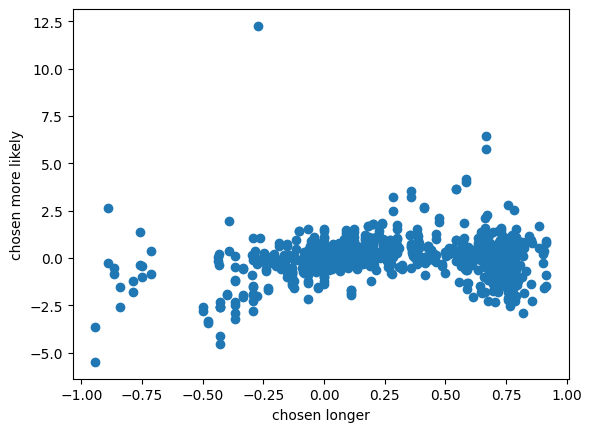

: 

In [39]:

print('are we biased by the length of the string? Ideally no correlation')
a, b = df_res2['_l_chosen'], df_res2['_l_rejected']
x = (a-b)/(a+b)
plt.plot(x, df_res2['_logratio'], 'o')
plt.xlabel('chosen longer')
plt.ylabel('chosen more likely')

# Damn this is not ideal....
a = df_res2['_l_chosen'] / df_res2['_l_rejected']
b = df_res2['prob']

m = np.isfinite(a) & np.isfinite(b)
a = a[m]
b = b[m]
corr_length = np.corrcoef(a, b)[1,0]
print(f'{corr_length:.2f} (0 is ideal) correlation between length ratio and prob:')
shypothesis('corr_length<0.25', locals())


print(f'is the ds bised? {a.mean()/b.mean():.2f} (1 is ideal)')
a=df_res2['prob']>0
b=x>=0
acc_bad = (a==b).mean()
print(f'{acc_bad:.2%} (0.5 is ideal) how often does it accurately pick the longer one :( ')

shypothesis('acc_bad<0.75', locals())